# White Swan AS Data Analysis Report

```
Date: 8 March 2018
Theme: Data validation and visual analysis
Authors: Luca Stey, Renier Botha
```

In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

sns.set()

%matplotlib inline

### Load all datasets

In [58]:
basmi_df = pd.read_excel('../data/clean_basmi.xls', index_col=(0,1))
normed_bs_df = pd.read_excel('../data/bs_normed_full.xls', index_col=0)
agg_bs_df = pd.read_excel('../data/bs_normed_agg.xls', index_col=0, header=[0,1])

# Demographics Data
demo_df = pd.read_excel('../data/demographics and Biologics data.xlsx')

## Age Distribution

Show what the age distribution is for the patients' "Age at diagnosis". This will give us an idea of what age do patients enter the study

**Process**:

First, remove patients from demographics data that we do not have BASMI data for and remove patients with any missing data.

Then, plot the age distribution for males and females and afterwards split the process for both genders

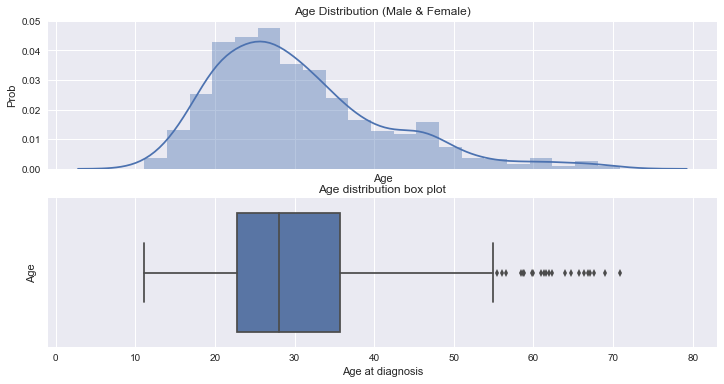

In [53]:
# Patients in BASMI dataset
basmi_patient_ids = set(bs_df.index.unique().values)
# Patients in Demographics dataset
demo_patient_ids = set(demo_df['patient_id'].unique())
# Patients in BOTH datasets
overlap_patient_ids = basmi_patient_ids.intersection(demo_patient_ids)

# Keep only overlapping patient data
demo_df = demo_df[demo_df['patient_id'].isin(list(overlap_patient_ids))]

# Remove the rows with missing values
demo_df.dropna(how='any',inplace=True)

# Overall distribution Plot
age_at_entry = demo_df['Age at diagnosis']

fig, ax_1 = plt.subplots(nrows=2, ncols=1, figsize=(12,6), sharex=True)
sns.distplot(age_at_entry, ax=ax_1[0])
ax_1[0].set_title('Age Distribution (Male & Female)')
ax_1[0].set_xlabel('Age')
ax_1[0].set_ylabel('Prob')

sns.boxplot(age_at_entry, ax=ax_1[1])
ax_1[1].set_title('Age distribution box plot')
ax_1[1].set_ylabel('Age')

plt.show()

It is observed that the age distribution is slightly positively skewed. Furthermore, the modal age at entry is approximately 25 years. This is younger than expected (by me at least). 

### Age distribution by gender

Split the process up for males and females

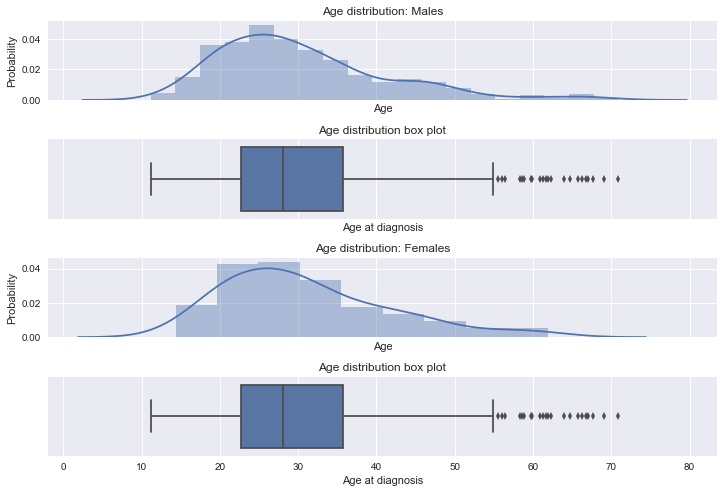

In [50]:
genders = demo_df['patient_gender_id']
# Get male and female index
male_ids = demo_df[genders == 'Male']['patient_id']
female_ids = demo_df[genders == 'Female']['patient_id']

# Get demographics about males and females
male_demo_df = demo_df[demo_df['patient_id'].isin(male_ids)]
female_demo_df = demo_df[demo_df['patient_id'].isin(female_ids)]

# Plot age at entry distribution for males and females
age_at_entry_male = male_demo_df['Age at diagnosis'].values
age_at_entry_female = female_demo_df['Age at diagnosis'].values

fig, ax_2 = plt.subplots(nrows=4,ncols=1,sharex=True, figsize=(12,8))
plt.subplots_adjust(hspace=0.5)
sns.distplot(age_at_entry_male, ax = ax_2[0])
ax_2[0].set_title('Age distribution: Males')
ax_2[0].set_xlabel('Age')
ax_2[0].set_ylabel('Probability')
sns.boxplot(age_at_entry, ax=ax_2[1])
ax_2[1].set_title('Age distribution box plot')

sns.distplot(age_at_entry_female, ax = ax_2[2] )
ax_2[2].set_title('Age distribution: Females')
ax_2[2].set_xlabel('Age')
ax_2[2].set_ylabel('Probability')
sns.boxplot(age_at_entry, ax=ax_2[3])
ax_2[3].set_title('Age distribution box plot')
plt.show()

It is seen that the shape of the two histograms are similar. Hence, there is not a massive difference between the age at entry of males and females. Notice that females are diagnosed at an earlier stage than males, although this is only a marginal difference.

# BS Score Over Time

Now we look at how the `BS` score progresses over time for the average patient.

>A more complete analysis can be found in the `bs-over-time.ipynb` notebook. 

To do this, we first _normalized_ the patient timelines so that the year in which the patient entered the study is set to 0 and the next year is 1 and so forth. Then the _average_ BS score is calculated for each year in the study as well as the number of patients that were included in the study for that many years. 

_For example, if patient A started in May 1998 and patient B started in June 2007 then the BS score of patient A in 1998 will be averaged with the BS score of patient B in 2007 for the year 0 in graph below, as 1998 and 2007 were the respective "0th" year in the study._

_If either patient had more than 1 measurement in their first year in the study, these measurements are averaged for that year to attain a single score per year in study, per patient._

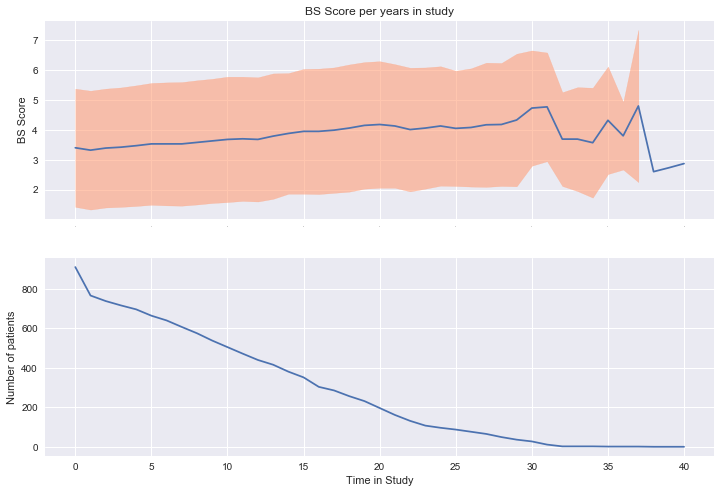

Number of patients in study at year 0 vs year 30 = 910 / 28


In [54]:
std_bs = agg_bs_df['BS', 'std']
mean_bs = agg_bs_df['BS','mean']
num_patients = agg_bs_df['count','len']

def plot_bs_over_time(mean_bs, std_bs, num_patients):
    fig = plt.figure(figsize=(12,8))
    ax1 = plt.subplot(211)
    plt.plot(mean_bs)
    plt.fill_between(mean_bs.index, y1=mean_bs+std_bs, y2=mean_bs-std_bs, color='lightsalmon', alpha=0.6)
    plt.setp(ax1.get_xticklabels(), fontsize=0)
    plt.title('BS Score per years in study')
    ax1.set_ylabel('BS Score')

    ax2 = plt.subplot(212, sharex=ax1)
    plt.plot(num_patients)
    ax2.set_xlabel('Time in Study')
    ax2.set_ylabel('Number of patients')

    plt.show()
    
plot_bs_over_time(mean_bs, std_bs, num_patients)

print(f'Number of patients in study at year 0 vs year 30 = {num_patients.loc[0]} / {num_patients.loc[30]}',)

#### Interpretation

Firstly, we can observe a approximately linear increase in BS score as time in study increases, while the number of patients in study also decreases approximately linearly. These observations are in line with what we expected.

Secondly, we can see that at around the 30 year mark there are very few patients in the study (28 vs 910 at start), which shows corresponding erratic measurements

We can see a high variability in the average BS score per year in study. This could be motivated by the fact that we are taking an average over patients that are in different phases of disease progression. For example, patient A might join the study with a BS score of 2 and patient B might join with a BS score of 4.2 - vastly different stages in disease progression, but both will be considered in the calculation of the mean BS score for `year-in-study = 0`.

Also, at the last few datapoints we only have 1 patient in the study, and thus the standard deviation is not defined. 

## Repeat the above analysis for both males and females

The first step is to identify which patients are male and female.

In [55]:
demo_df = pd.read_excel('../data/demographics and Biologics data.xlsx')

# Get patient ids of males and females
genders = demo_df['patient_gender_id'].values

# Get male and female index
male_ids = demo_df[genders == 'Male']['patient_id']
female_ids = demo_df[genders == 'Female']['patient_id']

# # Get BS dataset of males and females
male_bs_df = normed_bs_df.loc[male_ids]
female_bs_df = normed_bs_df.loc[female_ids]

## Plot BS score over time for males

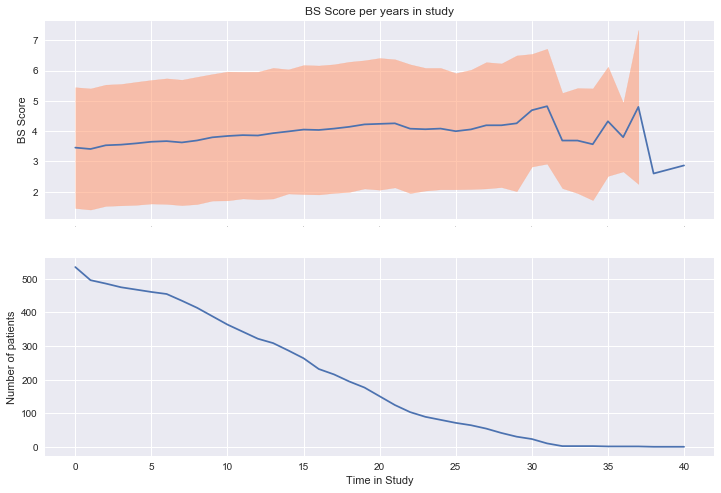

In [47]:
agg_male_df = (male_bs_df.groupby('norm_years')
                    .agg({'BS': ['mean','std'], 'norm_years': len})
                    .rename(columns={'norm_years': 'count'}))

std_bs = agg_male_df['BS', 'std']
mean_bs = agg_male_df['BS','mean']
num_patients = agg_male_df['count','len']

plot_bs_over_time(mean_bs, std_bs, num_patients)

## Plot BS over time for females

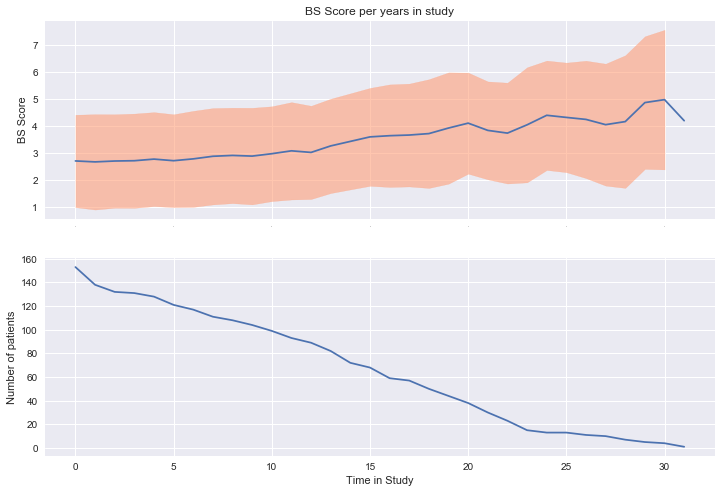

In [49]:
agg_female_df = (female_bs_df.groupby('norm_years')
                    .agg({'BS': ['mean','std'], 'norm_years': len})
                    .rename(columns={'norm_years': 'count'}))

std_bs = agg_female_df['BS', 'std']
mean_bs = agg_female_df['BS','mean']
num_patients = agg_female_df['count','len']

plot_bs_over_time(mean_bs, std_bs, num_patients)

## Average duration of treatment (drug / other) over all patients


## Average duration of treatment (days)

In [66]:
# List of drugs
drugs = [d for d in basmi_df['Drug'].unique() if not pd.isnull(d)]

# DataFrame to hold descriptive info
drugs_duration_df = pd.DataFrame(index = drugs, columns = ['avg_days','median_days','std_dev_days','count'] )


drugs_days = {drug: [] for drug in drugs}
for group, group_df in basmi_df.groupby(['Drug','patient_id']):
    start = min(group_df.index.get_level_values('Date'))
    end = max(group_df.index.get_level_values('Date'))
    
    days = pd.Timedelta(end-start).days
    
    drugs_days[group[0]].append(days)
      
for drug,days in drugs_days.items():
    drugs_duration_df.loc[drug] = [np.mean(days), np.median(days),np.std(days), len(days)]
    
drugs_duration_df

,avg_days,median_days,std_dev_days,count
Infliximab,3132.58,3256,890.052,12
Adalimumab,1763.2,1843,1155.04,75
Etanercept,2489.46,2677.5,1063.13,50
Certolizumab Pegol,11,11,0,1
Golimumab,405.5,361,381.702,8
Rituximab,1291,1291,850,2
